# Предварительный анализ данных

In [ ]:
import pandas as pd

df = pd.read_csv('../data/distance_graph_dataset.csv')

In [98]:
df.sample(10)

,n,distribution,chromatic_number,clique_number,max_independent_set_size,domination_number,min_clique_cover_size
7173,500,1,222,188,13,497,15
5774,300,0,89,83,11,296,13
4829,300,1,137,131,10,293,13
806,25,0,9,8,7,21,7
8647,100,1,41,39,8,80,9
9134,200,0,59,59,10,183,11
7289,100,1,48,37,7,95,8
8113,250,0,70,70,12,249,13
2024,250,0,82,82,11,233,13
7561,150,1,64,62,9,144,10


In [99]:
df.describe()

,n,distribution,chromatic_number,clique_number,max_independent_set_size,domination_number,min_clique_cover_size
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,249.610000,0.498500,97.644600,92.340800,9.639200,241.433100,11.446600
std,154.237566,0.500023,63.346749,59.820446,2.504766,152.512651,2.990592
min,25.000000,0.000000,6.000000,5.000000,2.000000,1.000000,2.000000
25%,100.000000,0.000000,43.000000,40.000000,8.000000,96.000000,9.000000
50%,250.000000,0.000000,93.000000,88.000000,10.000000,242.000000,12.000000
75%,400.000000,1.000000,143.000000,138.000000,11.000000,384.000000,14.000000
max,500.000000,1.000000,257.000000,250.000000,18.000000,500.000000,20.000000


In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   n                         10000 non-null  int64
 1   distribution              10000 non-null  int64
 2   chromatic_number          10000 non-null  int64
 3   clique_number             10000 non-null  int64
 4   max_independent_set_size  10000 non-null  int64
 5   domination_number         10000 non-null  int64
 6   min_clique_cover_size     10000 non-null  int64
dtypes: int64(7)
memory usage: 547.0 KB


**Небольшой анализ целевой переменной**

In [101]:
counts = df['distribution'].value_counts()
props = df['distribution'].value_counts(normalize=True)
print(counts, props)

distribution
0    5015
1    4985
Name: count, dtype: int64 distribution
0    0.5015
1    0.4985
Name: proportion, dtype: float64


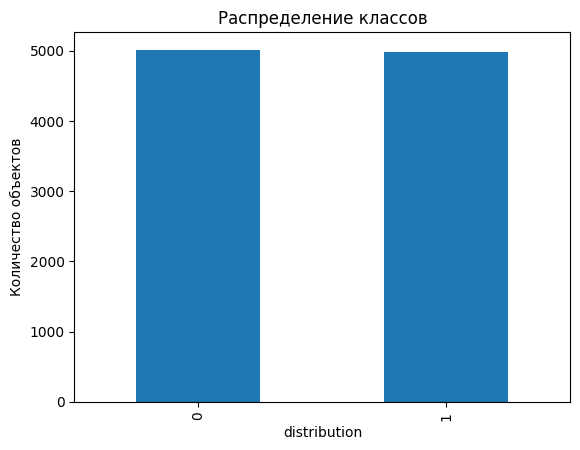

In [102]:
import matplotlib.pyplot as plt

counts.plot(kind='bar')
plt.title('Распределение классов')
plt.xlabel('distribution')
plt.ylabel('Количество объектов')
plt.show()

Оба класса распределны равномерно, их доли в датасете примерно равны.

**Построим pair plot** для визуализации:

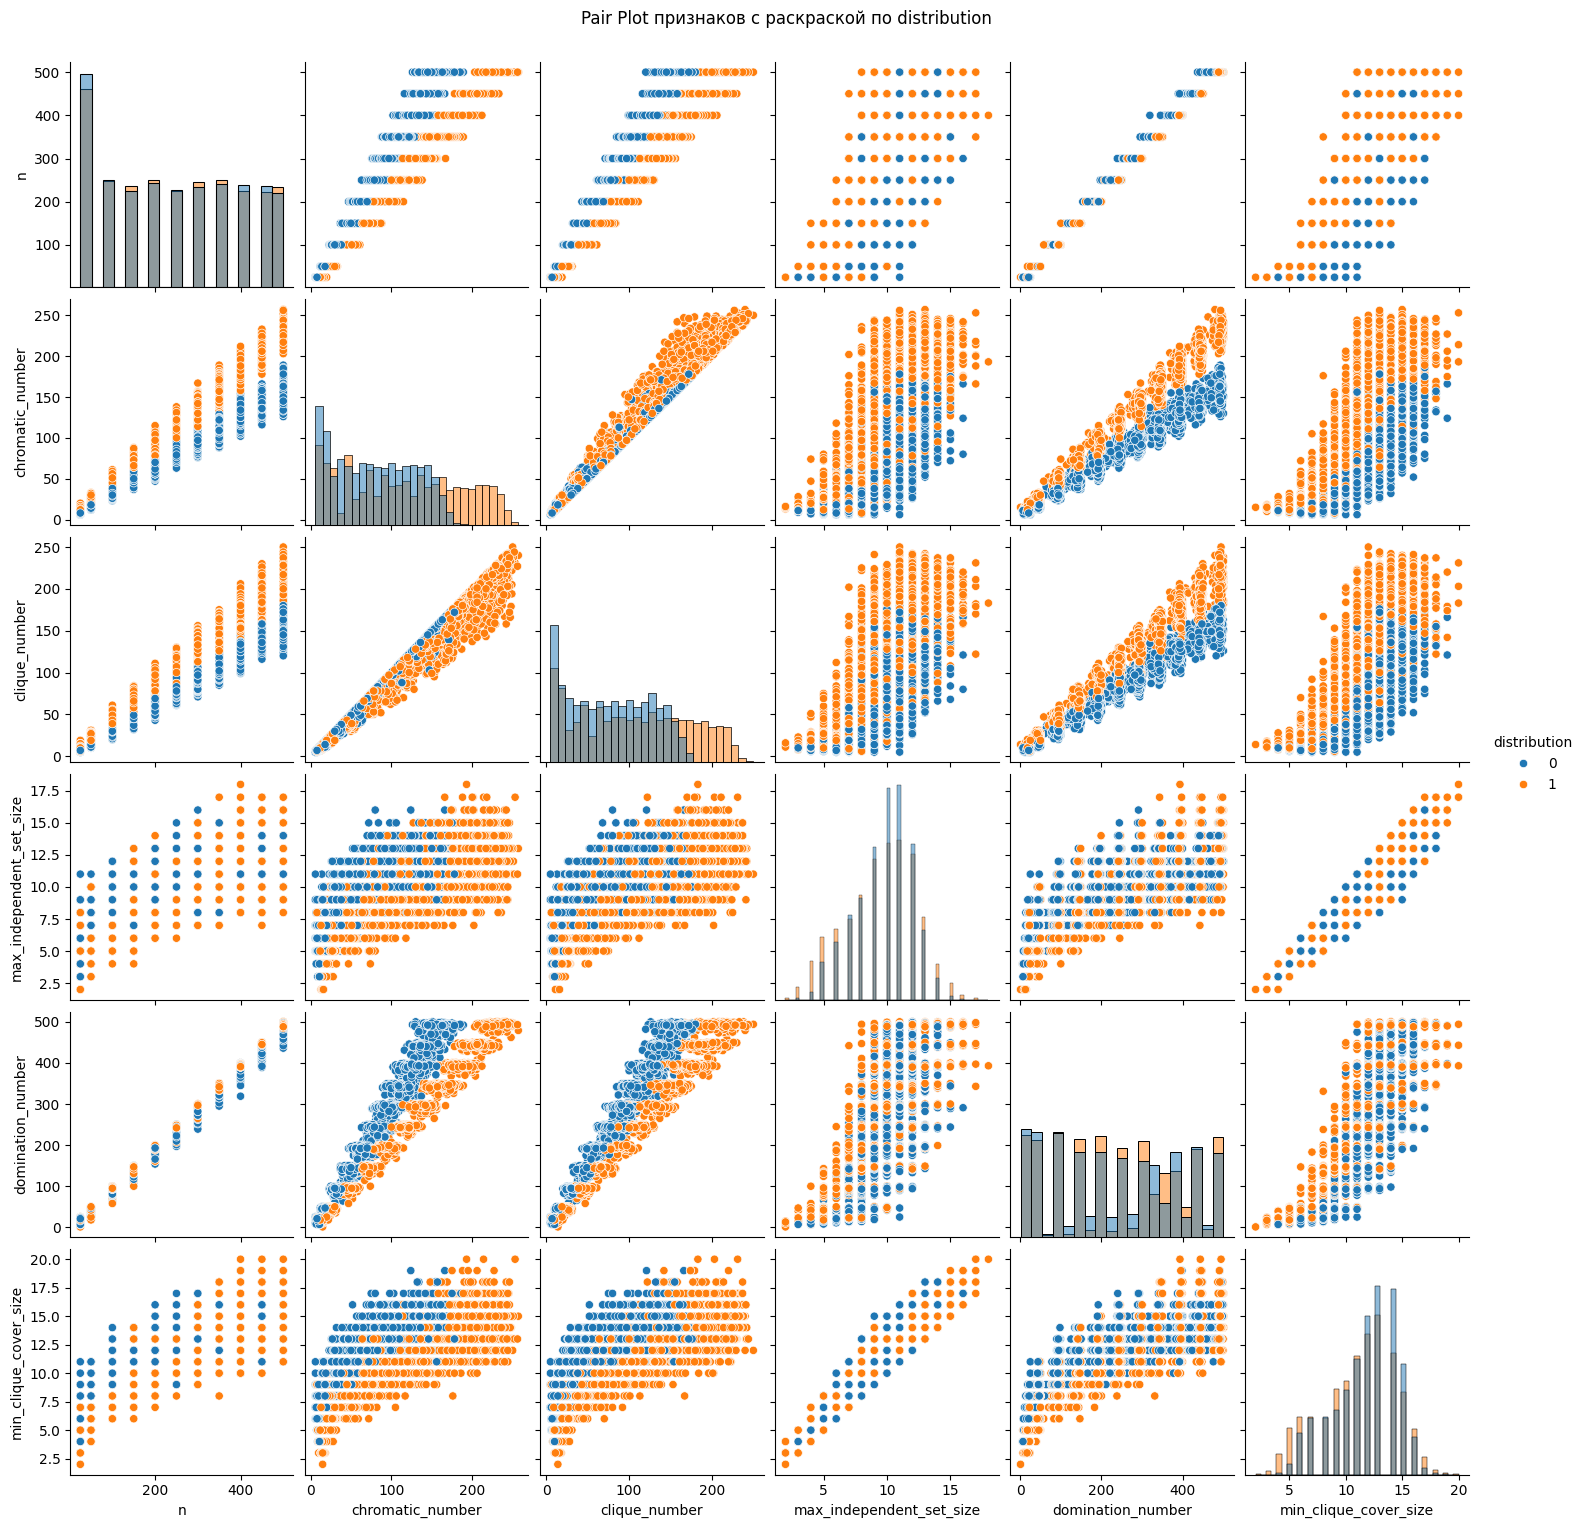

In [103]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(
    df,
    hue='distribution',
    vars=[
        'n',
        'chromatic_number',
        'clique_number',
        'max_independent_set_size',
        'domination_number',
        'min_clique_cover_size'
    ],
    diag_kind='hist'
)

plt.suptitle('Pair Plot признаков с раскраской по distribution', y=1.02)
plt.show()

**Выводы**
* самые важные признаки для классификации: `chromatic_number` и `clique_number`, они достаточно хорошо при всех `n` разделяют данную выборку на два класса
* при росте `n` важность характеристик не менятеся, по прежнему самы важные - это `chromatic_number` и `clique_number`, но качество предсказания заметно улучшается

**Между признаками прослеживаются зависимости:**
* `chromatic_number` и `clique_number` линейно зависят друг от друга
* `domination_number` линейно зависит от `chromatic_number` и `clique_number`
* `max_independent_set_size` и `min_clique_cover_size` линейно зависят друг от друга
* `max_independent_set_size` и `min_clique_cover_size` квадратично зависят от `domination_number`
* `max_independent_set_size` квадратично зависит от `chromatic_number` и `clique_number`
* `min_clique_cover_size` квадратично зависит от `chromatic_number` и `clique_number`

**Посмотрим на матрицу корреляций:**

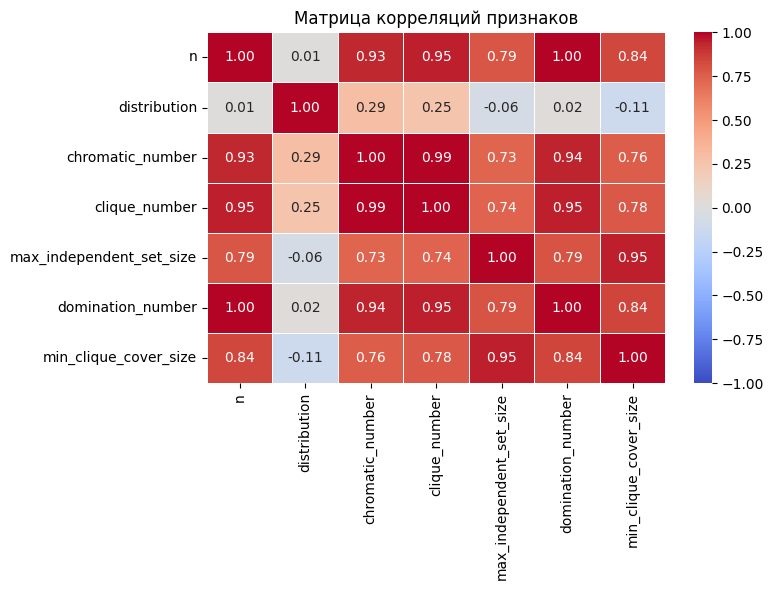

In [104]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1, vmax=1,
    linewidths=0.5
)
plt.title("Матрица корреляций признаков")
plt.tight_layout()
plt.show()

**Выводы**
* в целом тут мы можем найти подтверждения нашим выводам по `pair plot`
* больше всего с таргетом `distribution` коррелируют `chromatic_number` и `clique_number`
* `domination_number` имеет сильную корреляцию со всеми остальными признаками и очень слабую с таргетом, возможно, стоит попробовать его удалить
* `max_independent_set_size` и `min_clique_cover_size` имеют слабую корреляцию с таргетом, но довольно сильно зависят от других характеристик, возможно, стоит их как-то преобразовать

**Попробуем сгенерировать новые признаки**

In [105]:
import pandas as pd
import numpy as np

df['chromatic_number_norm']               = df['chromatic_number'] / df['n']
df['clique_number_norm']                  = df['clique_number'] / df['n']
df['max_independent_set_size_norm']       = df['max_independent_set_size'] / df['n']
df['domination_number_norm']              = df['domination_number'] / df['n']
df['min_clique_cover_size_norm']          = df['min_clique_cover_size'] / df['n']

df['chromatic_to_clique_ratio']           = df['chromatic_number'] / df['clique_number']
df['chromatic_to_max_independent_ratio']  = df['chromatic_number'] / df['max_independent_set_size']
df['clique_to_max_independent_ratio']     = df['clique_number']    / df['max_independent_set_size']
df['domination_to_clique_ratio']          = df['domination_number'] / df['clique_number']
df['min_clique_cover_to_chromatic_ratio'] = df['min_clique_cover_size'] / df['chromatic_number']

df['chromatic_minus_clique']              = df['chromatic_number'] - df['clique_number']
df['min_clique_cover_minus_chromatic']    = df['min_clique_cover_size'] - df['chromatic_number']
df['max_independent_plus_clique']         = df['max_independent_set_size'] + df['clique_number']

df['chromatic_number_sq']                 = df['chromatic_number'] ** 2
df['clique_number_sq']                    = df['clique_number'] ** 2
df['max_independent_set_size_sq']         = df['max_independent_set_size'] ** 2
df['chromatic_clique_product']            = df['chromatic_number'] * df['clique_number']

df['chromatic_number_log']                = np.log1p(df['chromatic_number'])
df['clique_number_sqrt']                  = np.sqrt(df['clique_number'])

df['n_sq']                                = df['n'] ** 2
df['n_inv']                               = 1   / df['n']

bins   = [0, 100, 300, df['n'].max()]
labels = ['small', 'medium', 'large']
df['n_bin'] = pd.cut(df['n'], bins=bins, labels=labels)
df = pd.get_dummies(df, columns=['n_bin'], drop_first=True)

df['chromatic_number_norm_x_clique_number_norm'] = (
    df['chromatic_number_norm'] * df['clique_number_norm']
)

print(df.shape)

(10000, 31)


Посмотрим, что получилось

In [106]:
df.sample(10)

,n,distribution,chromatic_number,clique_number,max_independent_set_size,domination_number,min_clique_cover_size,chromatic_number_norm,clique_number_norm,max_independent_set_size_norm,...,clique_number_sq,max_independent_set_size_sq,chromatic_clique_product,chromatic_number_log,clique_number_sqrt,n_sq,n_inv,n_bin_medium,n_bin_large,chromatic_number_norm_x_clique_number_norm
4888,500,1,237,180,14,493,17,0.474000,0.3600,0.028000,...,32400,196,42660,5.472271,13.416408,250000,0.002000,False,True,0.170640
1181,500,1,232,192,13,494,13,0.464000,0.3840,0.026000,...,36864,169,44544,5.451038,13.856406,250000,0.002000,False,True,0.178176
8170,300,0,101,93,10,292,12,0.336667,0.3100,0.033333,...,8649,100,9393,4.624973,9.643651,90000,0.003333,True,False,0.104367
6528,250,1,126,101,9,248,11,0.504000,0.4040,0.036000,...,10201,81,12726,4.844187,10.049876,62500,0.004000,True,False,0.203616
1452,300,0,89,78,11,293,14,0.296667,0.2600,0.036667,...,6084,121,6942,4.499810,8.831761,90000,0.003333,True,False,0.077133
644,500,0,155,155,11,490,16,0.310000,0.3100,0.022000,...,24025,121,24025,5.049856,12.449900,250000,0.002000,False,True,0.096100
2495,300,1,132,120,11,297,13,0.440000,0.4000,0.036667,...,14400,121,15840,4.890349,10.954451,90000,0.003333,True,False,0.176000
5042,50,0,14,14,6,48,7,0.280000,0.2800,0.120000,...,196,36,196,2.708050,3.741657,2500,0.020000,False,False,0.078400
9567,500,0,176,176,11,479,13,0.352000,0.3520,0.022000,...,30976,121,30976,5.176150,13.266499,250000,0.002000,False,True,0.123904
468,400,0,144,143,14,392,15,0.360000,0.3575,0.035000,...,20449,196,20592,4.976734,11.958261,160000,0.002500,False,True,0.128700


Построим матрицу корреляций с новыми признаками

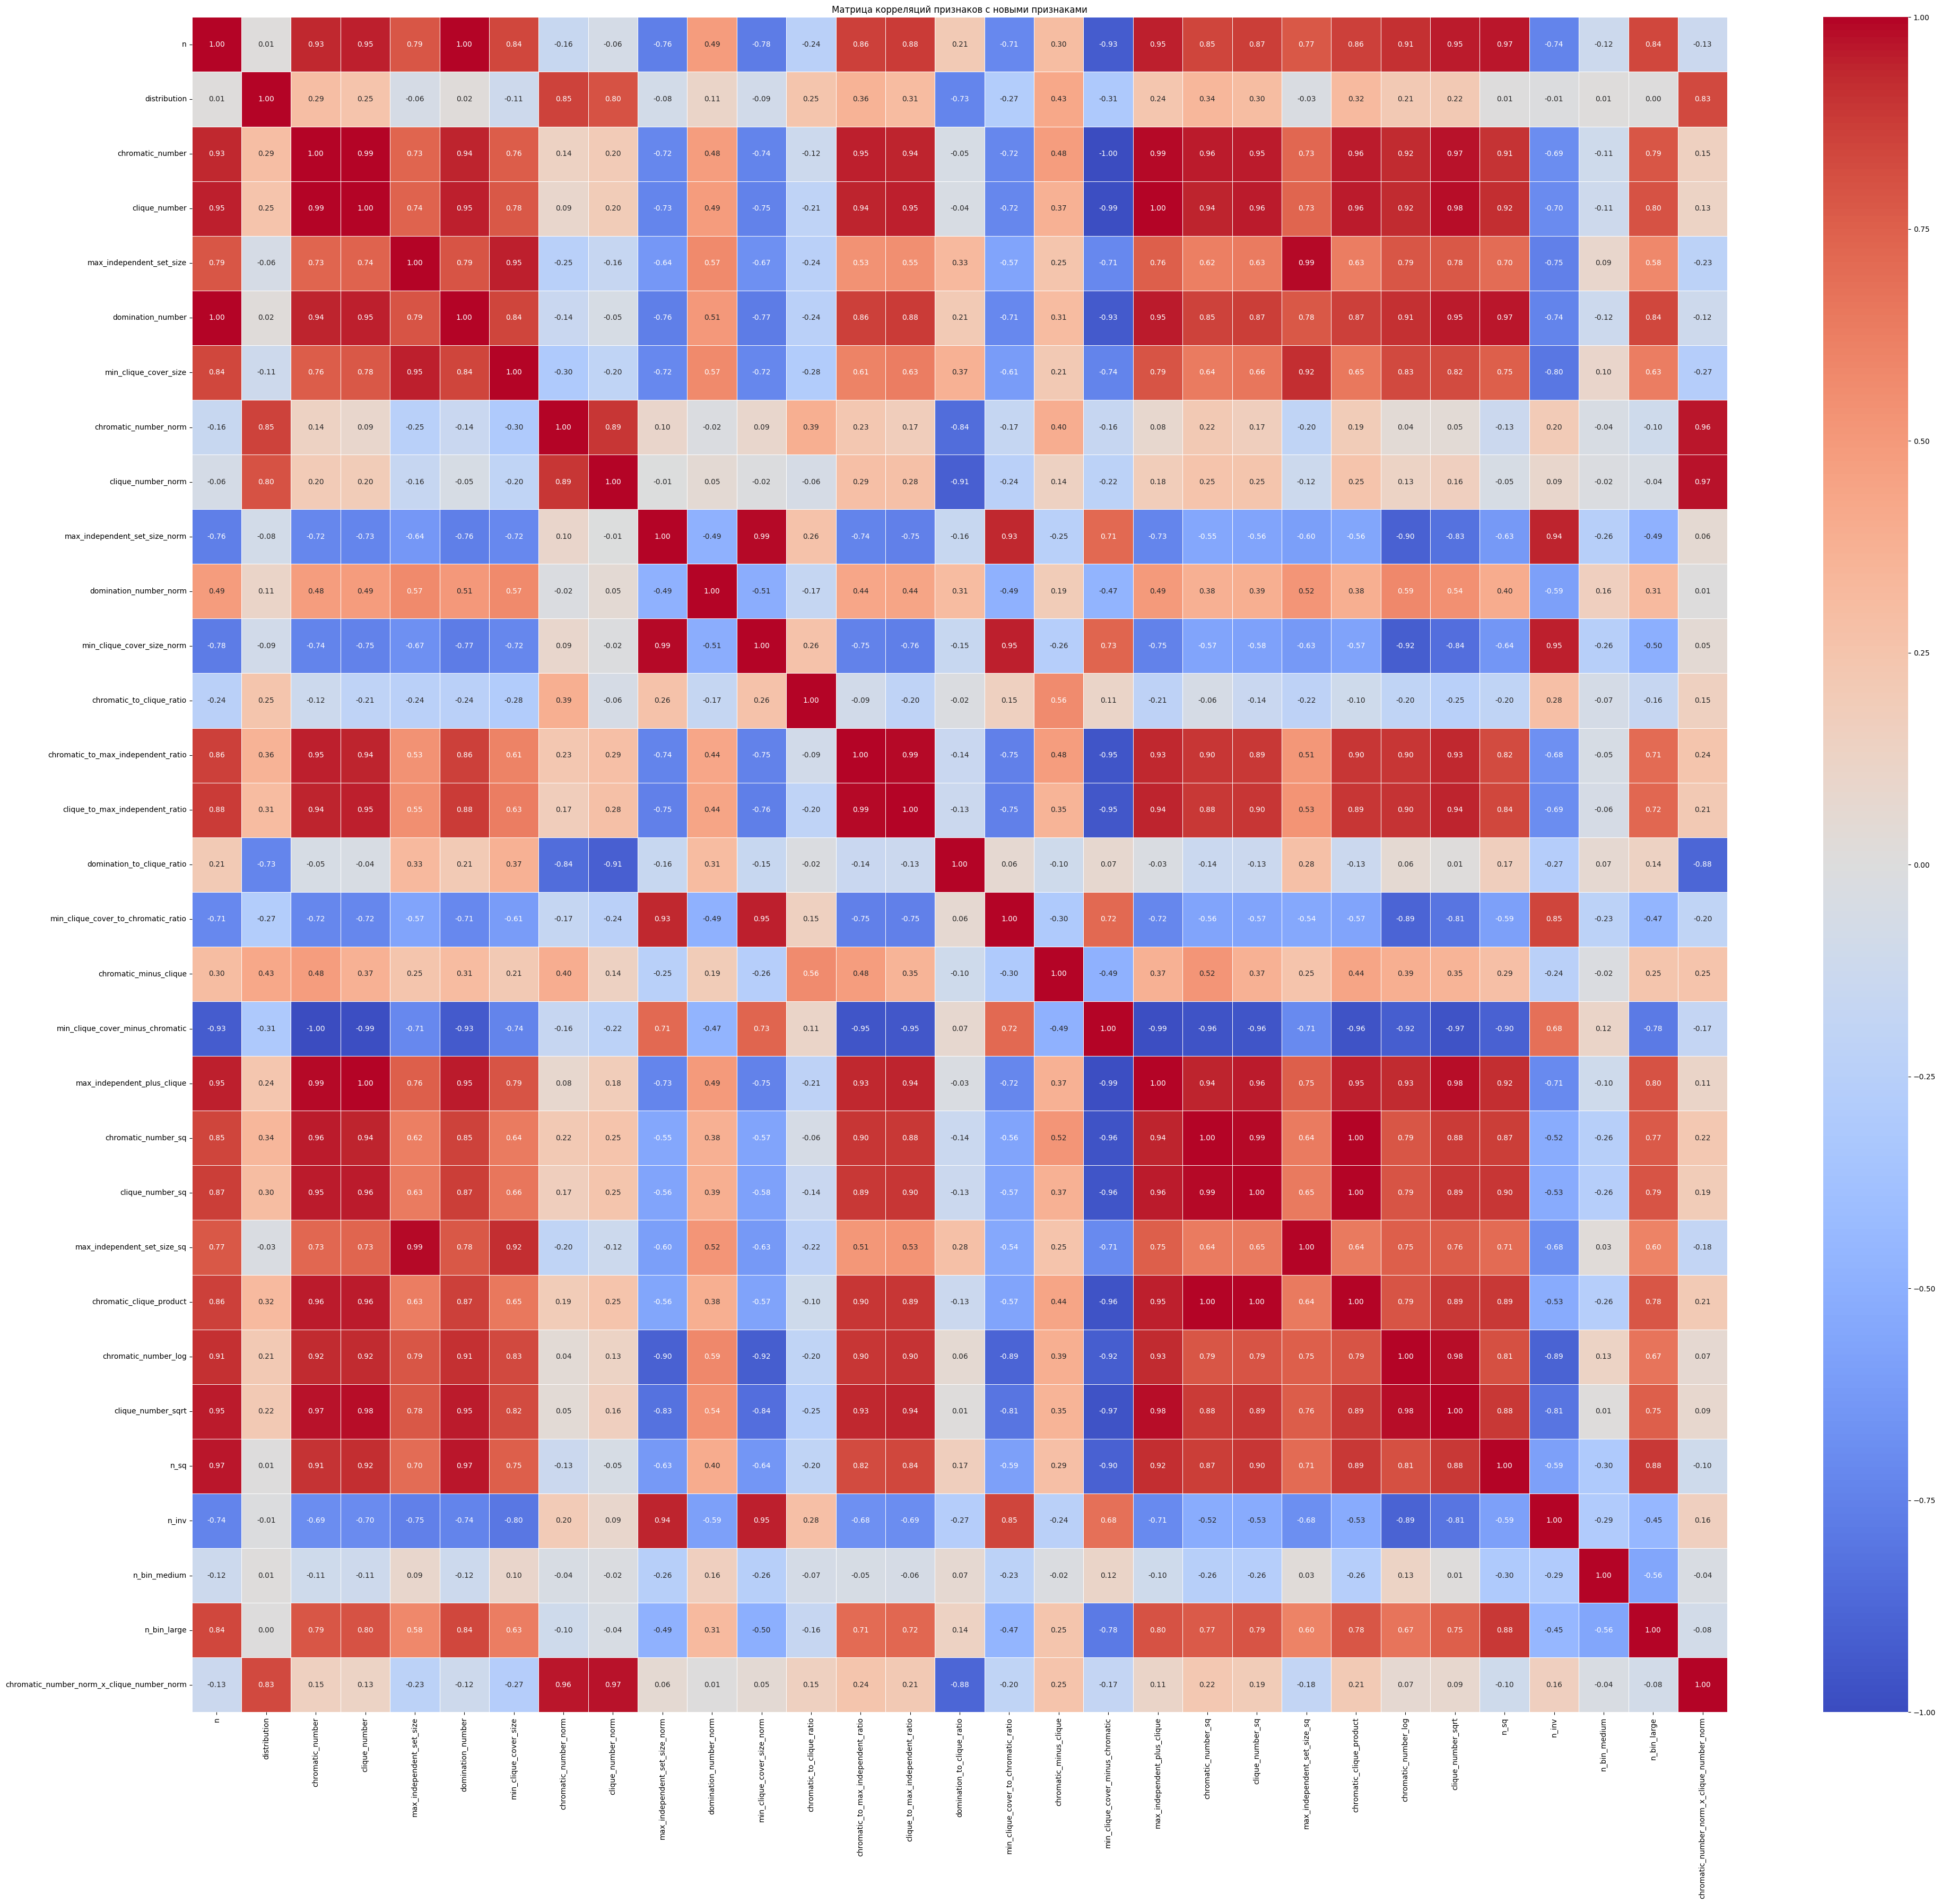

In [107]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = df.corr()

plt.figure(figsize=(40, 36))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1, vmax=1,
    linewidths=0.5
)
plt.title("Матрица корреляций признаков с новыми признаками")
plt.tight_layout()
plt.show()

**Вывод:** на мой взгляд мы получили достаточно неплохие результаты, так как у нас появилось несколько признаков, которые очень хорошо коррелируют с таргетом, например `chromatic_number_norm` и `clique_number_norm`.

Загрузим датасет с новыми признаками в файл:

In [ ]:
df.to_csv('../data/distance_graph_dataset_new_features.csv', index=False)

## Общий вывод

* самые важные признаки для классификации: `chromatic_number` и `clique_number`
* при росте `n` важность характеристик не изменяется, но граница между классами становится более отчетлива
* нормировка `chromatic_number` и `clique_number` по `n` дает корреляцию с таргетом более 80%

Возможно, при построении модели классификации следующие действия дадут прирост к качеству:
* преобразование `chromatic_number` и `clique_number` в один признак
* преобразование `max_independent_set_size`
* преобразование `min_clique_cover_size`
* удаление `domination_number`


## План на построения классификационных алгоритмов

**Метрики:** accuracy, precision, recall, F1-score, ROC AUC.

**Scaler:** StandartScaler

**Модели:**
1. **Baseline:** Логистическая регрессия (sklearn.linear_model.LogisticRegression), отобрать нужные признаки из новых с помощью L1 и L2
2. SVM (sklearn.svm.SVC): (kernel='linear')
3. SVM (sklearn.svm.SVC): (kernel='rbf') 
4. Random Forest (sklearn.ensemble.RandomForestClassifier)